**Import Necessary Libraries**

In [23]:
# Import Necessary Libraries
import zipfile
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import random


**Data Loading and Unzipping**

In [2]:
# Step 1: Unzip the Dataset
def unzip_data():
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('train')
    with zipfile.ZipFile('test.zip', 'r') as zip_ref:
        zip_ref.extractall('test')

unzip_data()



**Data Preprocessing**

In [3]:
# Step 2: Load and Preprocess the Images with HOG Features
def load_images_from_folder(folder, label, limit=None):
    images = []
    labels = []
    for filename in glob.glob(folder + '/*.jpg'):
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize images to 128x128 pixels
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hog_features = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
            images.append(hog_features)
            labels.append(label)
            if limit and len(images) >= limit:
                break
    return images, labels

# Load Training Images
cats, cat_labels = load_images_from_folder('train/cats', 0, limit=1000)  # Limit to 1000 images
dogs, dog_labels = load_images_from_folder('train/dogs', 1, limit=1000)  # Limit to 1000 images

# Combine the Training Data
X_train = np.array(cats + dogs)
y_train = np.array(cat_labels + dog_labels)



**Splitting the Dataset**

In [4]:
# Step 3: Split the Dataset
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


**Scale Features**

In [5]:
# Step 4: Scale Features
scaler = StandardScaler()
X_train_split = scaler.fit_transform(X_train_split)
X_val = scaler.transform(X_val)


**Model Building**

In [6]:
# Step 5: Train the SVM Model with Hyperparameter Tuning
print("Training SVM model...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)
grid_search.fit(X_train_split, y_train_split)

print("Best parameters found: ", grid_search.best_params_)
model = grid_search.best_estimator_
print("Model training complete.")


Training SVM model...
Best parameters found:  {'C': 1, 'kernel': 'rbf'}
Model training complete.


**Model Evaluation**

In [7]:
# Step 6: Evaluate the Model
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Validation Accuracy: 72.50%


**Load and Test on the Test Dataset**

In [8]:
# Step 7: Load and Test on the Test Dataset
def load_test_images(limit=None):
    test_cats, _ = load_images_from_folder('test/cats', 0, limit=limit)
    test_dogs, _ = load_images_from_folder('test/dogs', 1, limit=limit)
    return test_cats + test_dogs, [0]*len(test_cats) + [1]*len(test_dogs)

# Load Test Images
X_test, true_labels_test = load_test_images(limit=1000)  # Limit to 1000 images for testing

# Scale Test Features
X_test = scaler.transform(X_test)


**Making Predictions and Calculating Test Accuracy**

In [9]:
# Step 8: Make Predictions and Calculate Test Accuracy
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(true_labels_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 74.05%


**Displaying Confusion Matrix**

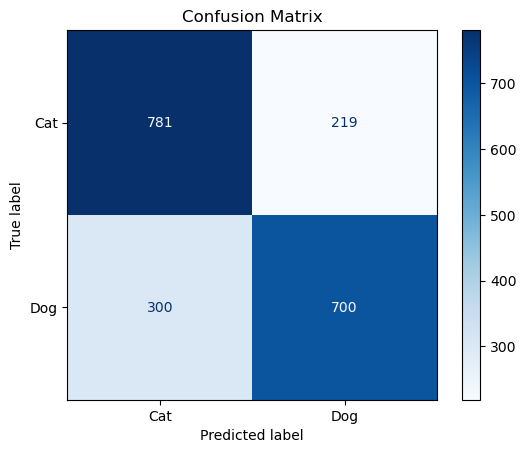

In [10]:
# Step 9: Display Confusion Matrix
cm = confusion_matrix(true_labels_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


**Classifying and Displaying a Specific Image**

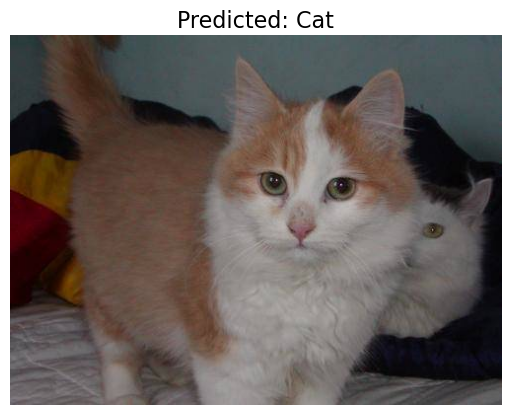

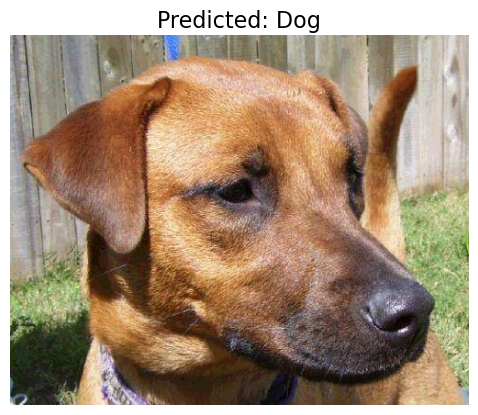

In [21]:
# Step 10: Classify and Display a Specific Image
def classify_and_display_image(image_path, model, scaler):
    img = cv2.imread(image_path)
    if img is not None:
        img_resized = cv2.resize(img, (128, 128))  # Resize to match the training size
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        hog_features = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
        
        # Scale the features
        hog_features_scaled = scaler.transform([hog_features])
        
        prediction = model.predict(hog_features_scaled)
        label = 'Cat' if prediction[0] == 0 else 'Dog'
        
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Predicted: {label}', fontsize=16)
        plt.axis('off')
        plt.show()

# Example Usage of Classifying and Displaying Images (replace with actual image paths)
classify_and_display_image('test/cats/cat.3284.jpg', model, scaler)  # Replace with an actual path
classify_and_display_image('test/dogs/dog.2044.jpg', model, scaler)  # Replace with an actual path


**Displaying Random Images with True and Predicted Labels**

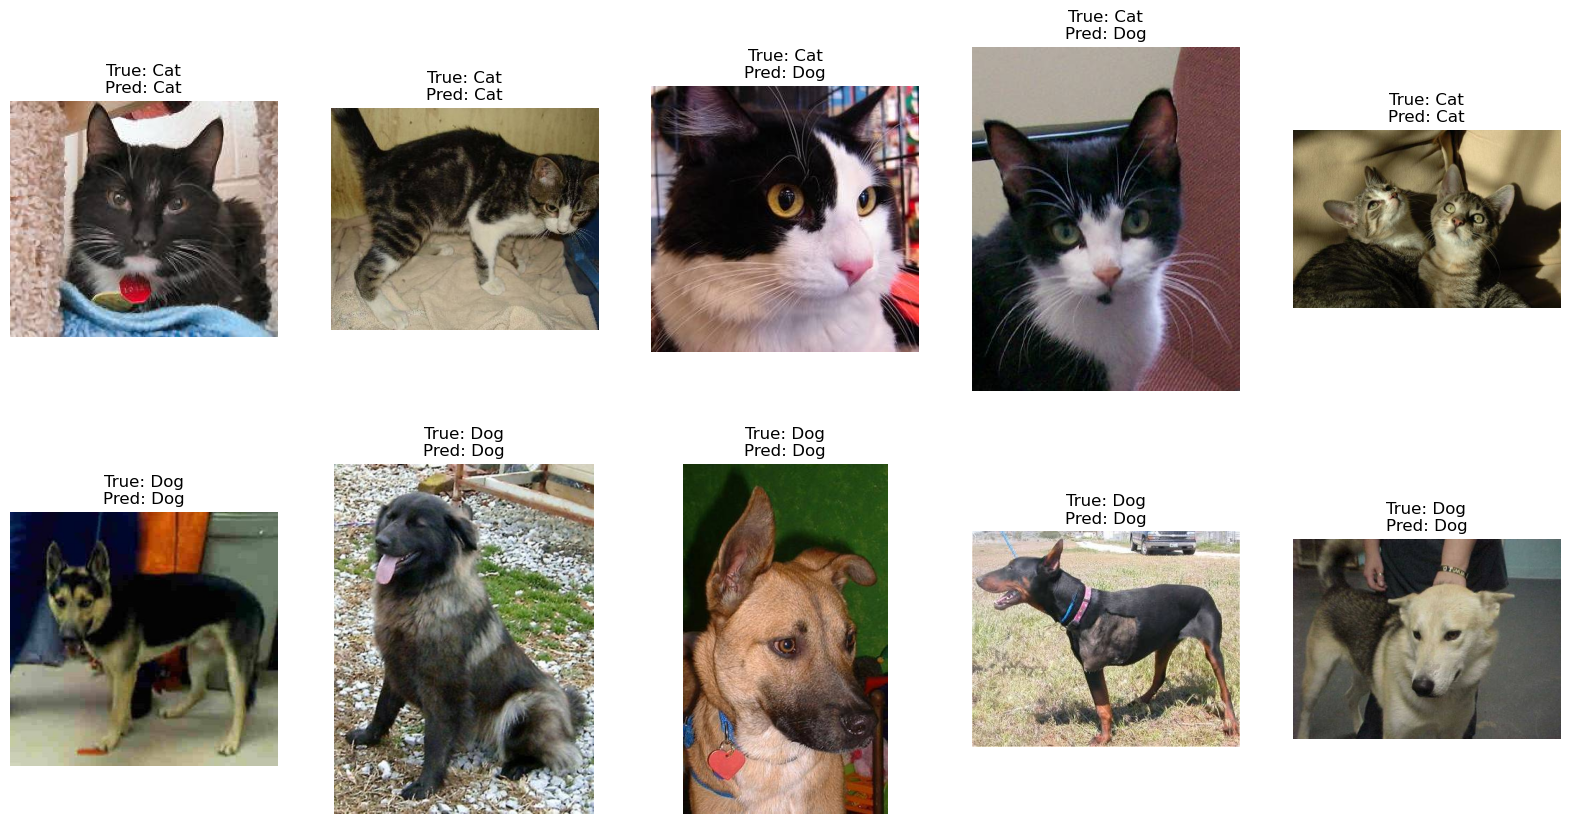

In [22]:
# Step 11: Display Random Images with True and Predicted Labels
def load_random_images(folder, label, num_images=5):
    """
    Load a specific number of random images from a folder.
    """
    image_files = glob.glob(folder + '/*.jpg')
    random_files = random.sample(image_files, num_images)  # Randomly sample image files
    images = []
    labels = []
    for filename in random_files:
        img = cv2.imread(filename)
        img = cv2.resize(img, (128, 128))  # Resize images to 128x128 pixels
        if img is not None:
            # Convert to grayscale and extract HOG features
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hog_features = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
            images.append(hog_features)
            labels.append(label)
    return images, labels

def display_random_images(num_images=5):
    """
    Display random images from both cats and dogs datasets with their true and predicted labels.
    """
    # Load random images
    cat_images, cat_labels = load_random_images('train/cats', 0, num_images=num_images)
    dog_images, dog_labels = load_random_images('train/dogs', 1, num_images=num_images)
    
    # Combine data
    X_random = np.array(cat_images + dog_images)
    y_random = np.array(cat_labels + dog_labels)
    
    # Scale features
    X_random_scaled = scaler.transform(X_random)
    
    # Make predictions
    y_random_pred = model.predict(X_random_scaled)
    
    # Original images
    cat_image_files = glob.glob('train/cats/*.jpg')
    dog_image_files = glob.glob('train/dogs/*.jpg')
    cat_random_images = [cv2.imread(random.choice(cat_image_files)) for _ in range(num_images)]
    dog_random_images = [cv2.imread(random.choice(dog_image_files)) for _ in range(num_images)]
    original_images = cat_random_images + dog_random_images
    
    # Display images
    plt.figure(figsize=(20, 10))
    for i in range(num_images * 2):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
        plt.axis('off')
        plt.title(f'True: {"Cat" if y_random[i] == 0 else "Dog"}\nPred: {"Cat" if y_random_pred[i] == 0 else "Dog"}', fontsize=12)
    plt.show()

# Display random images
display_random_images(num_images=5)